# Proof of concept Pipeline: Subpopulation A, Physics and Medicine

In [1]:
import os
import numpy as np 
import pandas as pd 
from copy import deepcopy
import pprint
from collections import defaultdict
from catboost import CatBoostRegressor, CatBoostClassifier

In [2]:
from causal_eval.causal_inference_algorithms import baseline_estimation_all_seeds, dataset_checks, baseline_estimation_one_seed
from causal_eval.ml_utils import COUNTVECTORIZER,predict_y_from_X_crossfit
from causal_eval.utils import *
from causal_eval.sampling import *

import seaborn as sns
import matplotlib.pyplot as plt


Load data

In [3]:
fname = '../data/subpopA_physics_medicine.csv'
data = pd.read_csv(fname)

In [4]:
data.head()

,X,Y,T,C
0,Thyroid function and prevalent and incident me...,0,0,0
1,An open-system quantum simulator with trapped ...,0,1,1
2,On Thermodynamic Interpretation of Copula Entr...,0,1,1
3,Exact Landau Level Description of Geometry and...,0,0,1
4,Introduction to the Quantum Theory of Elementa...,1,1,1


In [5]:
rct_stats = dataset_checks(data)

==== DATASET CHECKS ====
Num observations= 4379
Num duplicate papers =  502 (11.46%)
C=1, C=0 balance= 0.8173098881023064
Odds ratio (Y, C)= 1.7722050845654718
RCT_ATE =  0.09557700480435129
Mean Y =  0.06736697876227449
T=1%  0.47978990637131763


In [6]:
# Print out for Data Table 
ss = fname.split('/')[-1].rstrip('csv').split('_')
cat1 = ss[1].rstrip('.')
cat2 = ss[2].rstrip('.')
cat1, cat2

('physics', 'medicine')

In [7]:
# Prepare X vector
print(COUNTVECTORIZER)
vec = deepcopy(COUNTVECTORIZER)
texts = data['X'].to_numpy()
X = vec.fit_transform(texts).toarray()
print('Vocab length =', len(vec.get_feature_names_out()))

CountVectorizer(binary=True, max_df=0.9, max_features=2000, min_df=5,
                preprocessor=<function preprocess_text at 0x1498071f0>,
                stop_words='english', strip_accents='unicode')
Vocab length = 2000


Accuracy of P(C|X)

In [8]:
C = data['C'].to_numpy().astype(int)

In [9]:
scores, C_predictions = predict_y_from_X_crossfit(X,
    C,
    y_learning_task="binary",
    n_crossfit=4,
    n_innercv=4,
    n_jobs=10,
    random_state=0)
scores

{'f1': 0.9842068483577917,
 'acc': 0.9741950216944508,
 'mean_hard_pred': 0.8166248001826901,
 'mean_true': 0.8173098881023064,
 'roc_auc': 0.993851983794356,
 'ave_prec': 0.9986339838060335,
 'calibration_rmse': 0.07759075808729501,
 'mean_soft_pred': 0.8025121025754475}

Diagnostic plots for selecting parameterization of P(T|C)

saved to::  imgs/physics-medicine-diagnostics.png


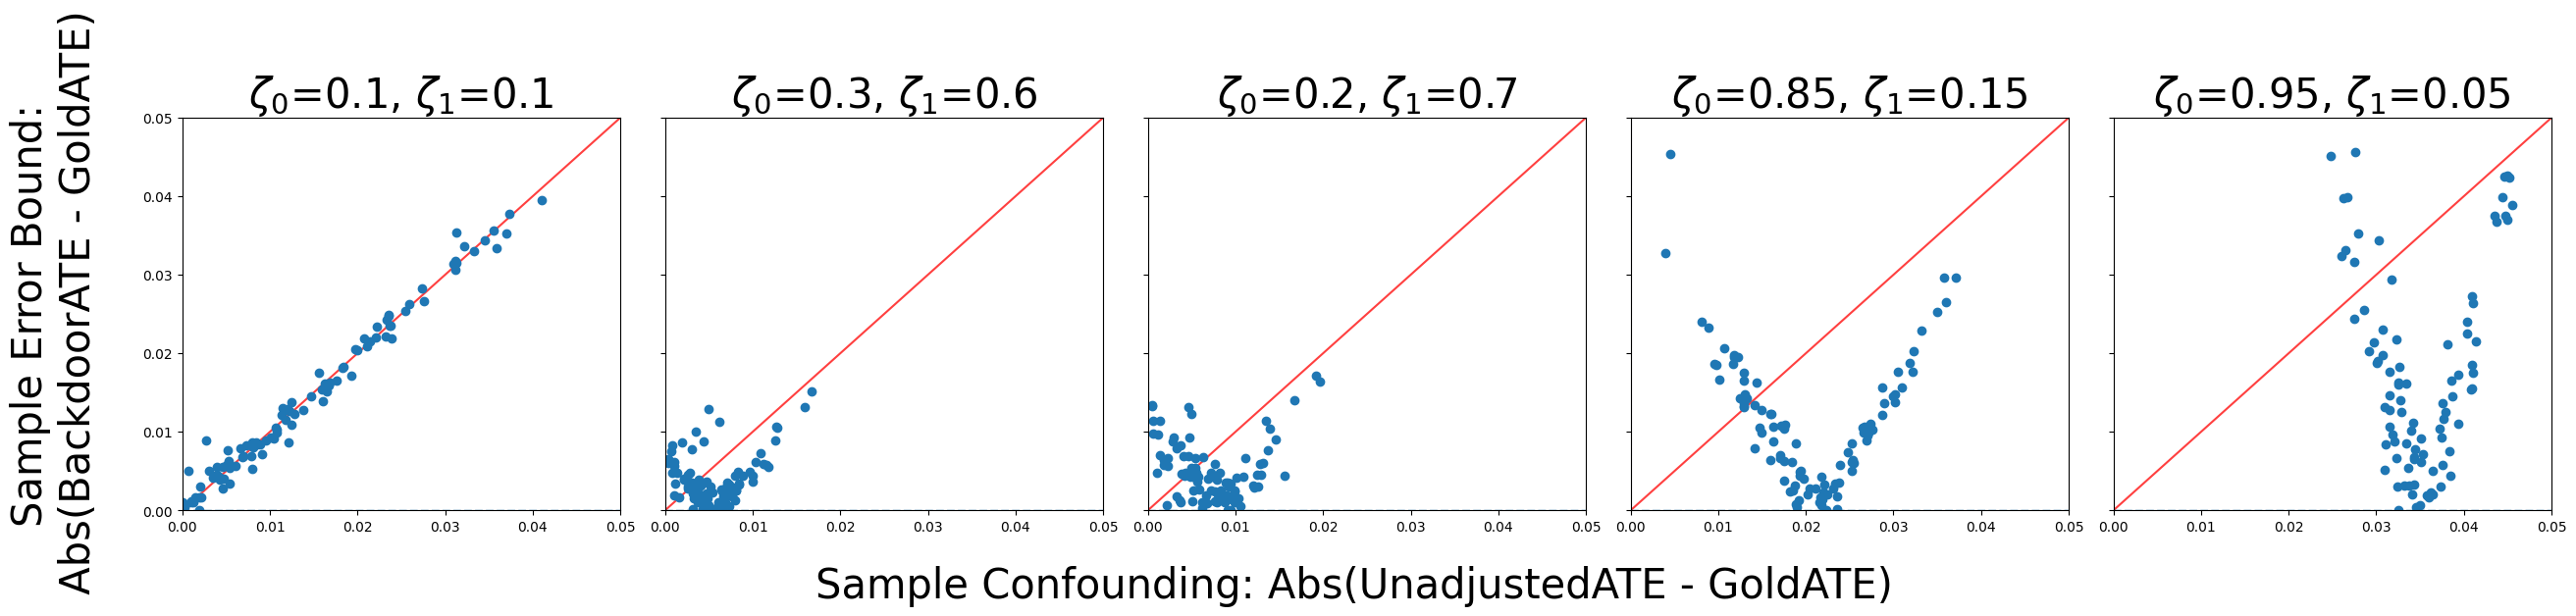

In [10]:
##### SET MANUALLY ########
num_seeds_one_setting = 100 
zeta0_zeta1_list = [(.1, .1), (0.3, 0.6), (0.2, 0.7),(0.85, 0.15), (0.95, 0.05)]
########################### 
#will save to imgs folder
if not os.path.exists('imgs/'): os.mkdir('imgs/')

fig = diagnostic_plot(data, zeta0_zeta1_list, 'imgs/physics-medicine-diagnostics.png', num_seeds_one_setting = num_seeds_one_setting)

Select a parameterization of P(T|C) for the remainder of the estimation pipeline. Here we'll choose $zeta_0=0.85$, $zeta_1=0.15$

In [11]:
##### SET MANUALLY ########
num_seeds_one_setting = 100 
zeta0, zeta1 = 0.85, 0.15
########################### 

In [12]:
x, y, data_resampled_all_seeds = one_hyperparam_setting(data, zeta0, zeta1, num_seeds_one_setting)
data_resampled_dict_all_seeds = resampled_data_cleanup(data_resampled_all_seeds, vec)

Estimation pipeline

In [13]:
# Create a training folder for catboost 
if not os.path.exists('catboost_train/'): os.mkdir('catboost_train/')

In [14]:
# set estimation configs here
expname2config = {} 

#some configs that never change
est_config_base = {
        "n_crossfit": 2,
        "n_repeats": 1,
        "n_jobs_obs_samp": 10,
        "est_g_func": "BOW",
        "y_model": None,  # leave at default
        "t_model": None,  # leave at default
        "y_model_grid": None,
        "t_model_grid": None,
        "propensity_score_cutoff": 0.01, #all models that have propensity score things 
        "n_innercv": 2, #let's keep CV on for now 
        "y_learning_task": "binary" #binary or real-valued
    }

# two settings here: one in which the base model is catboost and the other in which its just logistic/linear regression 
expname2config['no_catboost'] = deepcopy(est_config_base) | {
        "config_id": "2023-07-25-no_catboost",
        "use_catboost": False
    }

expname2config['catboost'] = deepcopy(est_config_base) | {
        "config_id": "2023-07-25-catboost",
        "use_catboost": True, 
        "y_model": CatBoostClassifier(thread_count=1, verbose=False, train_dir='catboost_train/'), 
        "t_model": CatBoostClassifier(thread_count=1, verbose=False, train_dir='catboost_train/')
    }

In [15]:
# Development: make sure just a single estimation runs first 
baseline_estimation_one_seed(data_resampled_dict_all_seeds[0], expname2config['catboost'], n_jobs=10)

{'results': {'outcome_regression_ate': 0.08802588559369043,
  'outcome_regression_ate_ci': (0.0850141971119071, 0.09103757407547376),
  'IPTW_ate': 0.11867418576843175,
  'IPTW_ate_ci': (0.0812023654428425, 0.15614600609402102),
  'AIPTW_ate': 0.10345915533877921,
  'AIPTW_ate_ci': (0.06701010656732079, 0.13990820411023763),
  'double_ml_ate': 0.1056745682018005,
  'double_ml_ate_ci': (0.10524542394747555, 0.10610371245612546),
  'naive_ate': 0.08745527204628298,
  'backdoor_c_ate': 0.11962296628069903},
 'train_pred_model_report_out': {'treatment_model---f1': 0.7622439893143367,
  'treatment_model---acc': 0.8905289052890529,
  'treatment_model---mean_hard_pred': 0.1816318163181632,
  'treatment_model---mean_true': 0.2788027880278803,
  'treatment_model---roc_auc': 0.9870192790021068,
  'treatment_model---ave_prec': 0.9656455699733911,
  'treatment_model---calibration_rmse': 0.24837792939763495,
  'treatment_model---mean_soft_pred': 0.2768531759942362,
  'y_model_Tlearner_T=0---f1': 0.

In [16]:
# supress convergence warnings (comment out if you want these)
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [17]:
# All estimations (takes about 70 mins to run)
expname2results = {}
for expname, est_methods_config in expname2config.items():
    expname2results[expname] = baseline_estimation_all_seeds(data_resampled_dict_all_seeds, est_methods_config)

fitting estimation models


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 53.9min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 82.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


fitting estimation models


[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  6.6min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed: 11.5min finished


Printouts for Latex Table 

In [18]:
# Prediction printouts

In [19]:
#### SET MANUALLY ##############
expname = 'no_catboost'
expname_for_print = 'linear' #what you want to printout in the latex table
desired_pred_metric = 'ave_prec'
##################################
_ = print_predictive_one_experiment(expname, expname_for_print, desired_pred_metric, expname2results, num_seeds_one_setting)

PREDICTIVE MODELS
METRIC = ave_prec
 & treatment_model &  & y_model_Tlearner_T=0 &  & y_model_Tlearner_T=1 &  & y_model_both & 
 & train & inf & train & inf & train & inf & train & inf

linear& 0.89 (0.07) \cellcolor {yellow!89.0}& 0.59 (0.02) \cellcolor {green!59.0}& 0.64 (0.31) \cellcolor {yellow!64.0}& 0.03 (0.01) \cellcolor {green!3.0}& 0.85 (0.17) \cellcolor {yellow!85.0}& 0.13 (0.03) \cellcolor {green!13.0}& 0.7 (0.2) \cellcolor {yellow!70.0}& 0.06 (0.01) \cellcolor {green!6.0}


In [20]:
#### SET MANUALLY ##############
expname = 'catboost'
expname_for_print = 'catboost (nonlinear)' #what you want to printout in the latex table
desired_pred_metric = 'ave_prec'
##################################
_ = print_predictive_one_experiment(expname, expname_for_print, desired_pred_metric, expname2results, num_seeds_one_setting)

PREDICTIVE MODELS
METRIC = ave_prec
 & treatment_model &  & y_model_Tlearner_T=0 &  & y_model_Tlearner_T=1 &  & y_model_both & 
 & train & inf & train & inf & train & inf & train & inf

catboost (nonlinear)& 0.97 (0.0) \cellcolor {yellow!97.0}& 0.6 (0.02) \cellcolor {green!60.0}& 1.0 (0.0) \cellcolor {yellow!100}& 0.03 (0.01) \cellcolor {green!3.0}& 0.99 (0.01) \cellcolor {yellow!99.0}& 0.13 (0.02) \cellcolor {green!13.0}& 0.98 (0.01) \cellcolor {yellow!98.0}& 0.05 (0.01) \cellcolor {green!5.0}


In [21]:
# Causal estimation printouts 

In [22]:
# Ground truth RCT ACE 
rct_ace =  parametric_backdoor(data, "Y", "T", [])
print("RCT ACE unadjusted", rct_ace)
print("RCT ACE adjusting for C", parametric_backdoor(data, "Y", "T", ["C", "T*C"])) # perform some sanity checks
                                                                                    # in the RCT data we should see unadjusted == adjusted 

RCT ACE unadjusted 0.09557700480434869
RCT ACE adjusting for C 0.0952944578754851


In [23]:
#### SET MANUALLY ##############
expname = 'no_catboost'
expname_for_print = 'linear' #what you want to printout in the latex table
desired_pred_metric = 'ave_prec'
##################################
_ = print_estimation_one_experiment(expname, expname_for_print, expname2results, num_seeds_one_setting, rct_ace)

CAUSAL ESTIMATION: RELATIVE ABSOLUTE ERROR
& naive& backdoor_c& outcome_regression& IPTW& AIPTW& double_ml

linear& 0.21 (0.08)& 0.12 (0.09)& 1.48 (1.05)\cellcolor {red!100}& 0.47 (0.16)\cellcolor {red!47.0}& 1.57 (0.66)\cellcolor {red!100}& 1.93 (0.92)\cellcolor {red!100}


In [24]:
#### SET MANUALLY ##############
expname = 'catboost'
expname_for_print = 'catboost (nonlinear)' #what you want to printout in the latex table
desired_pred_metric = 'ave_prec'
##################################
_ = print_estimation_one_experiment(expname, expname_for_print, expname2results, num_seeds_one_setting, rct_ace)

CAUSAL ESTIMATION: RELATIVE ABSOLUTE ERROR
& naive& backdoor_c& outcome_regression& IPTW& AIPTW& double_ml

catboost (nonlinear)& 0.21 (0.08)& 0.12 (0.09)& 0.24 (0.1)\cellcolor {red!24.0}& 0.14 (0.11)\cellcolor {red!14.0}& 0.11 (0.1)\cellcolor {red!11.0}& 0.13 (0.1)\cellcolor {red!13.0}


In [25]:
# Table caption printout
table_caption = f"""
Results on an RCT for which we have chosen two structured (low-dimensional) confounders that are 
categories of articles: {cat1} and {cat2}.
For this RCT, n={rct_stats['num_observations']}, 
the RCT ATE is {np.round(rct_stats['rct_ate'], 3)}
and the odds ratio
between the two binary categories and Y is {np.round(rct_stats['odds_ratio'], 2)}. 
For sampling to create a confounded dataset, we choose $\zeta_0=$ {zeta0} and $\zeta_1=$ {zeta1}. 
"""
print(table_caption)


Results on an RCT for which we have chosen two structured (low-dimensional) confounders that are 
categories of articles: physics and medicine.
For this RCT, n=4379, 
the RCT ATE is 0.096
and the odds ratio
between the two binary categories and Y is 1.77. 
For sampling to create a confounded dataset, we choose $\zeta_0=$ 0.85 and $\zeta_1=$ 0.15. 

